# LAB 5: Time series forecasting

This last LAB addresses the common problem of modelling time series data in order to make predictions about the future behaviour. 
More specifically, we will explore the [**London Santander Cycle data**](https://data.london.gov.uk/dataset/number-bicycle-hires) provided by Transport for London. 

As reported on the TfL website, the dataset includes the total number of hires of the Santander Cycle Hire Scheme, by day, month and year for each day since the launch on 30 July 2010.

For the purposes of this LAB, we are interested only in the daily data (i.e. columns A and B).

![TFLdatapreview](tfl_data_preview.png)

## Load relevant packages

In [1]:
import pickle 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from calendar import day_abbr, month_abbr, mdays

## Load data and plot

The dataset contains two sheets: `Metadata` and `Data`. Therefore, we need to tell Pandas which one we want to look at via the `sheet_name` attribute of the `read_excel` method. Moreover, since there is no need to load data that we are not interested in, it is recommended to also specify the columns that we want to use.

**NOTE** the timestamp (which is `Day` in the Excel file) is renamed `datetime` due to a common practice in Pandas. Also, we are selecting the dates from the 1st of Jan 2011 because the climate data that we will be using later in the LAB is from this date onwards.

In [44]:
def load_tfl_cycle_data():
    #iloc shows the columns we want (first 2)
    cycle_df = pd.read_csv('./tfl-daily-cycle-hires.csv').iloc[:, 0:2]
    cycle_df = cycle_df.rename(columns={'Day':'datetime'})
    cycle_df['datetime'] = pd.to_datetime(cycle_df['datetime'])
    cycle_df = cycle_df.set_index('datetime', drop=True)
    cycle_df = cycle_df.loc['2011-01-01':, :]
    
    return cycle_df

In [45]:
cycle_df = load_tfl_cycle_data()
cycle_df

,Number of Bicycle Hires
datetime,
2011-01-01,"4,555"
2011-02-01,"6,250"
2011-03-01,"7,262"
2011-04-01,"13,430"
2011-05-01,"13,757"
...,...
2020-09-26,"34,338"
2020-09-27,"26,681"
2020-09-28,"33,130"


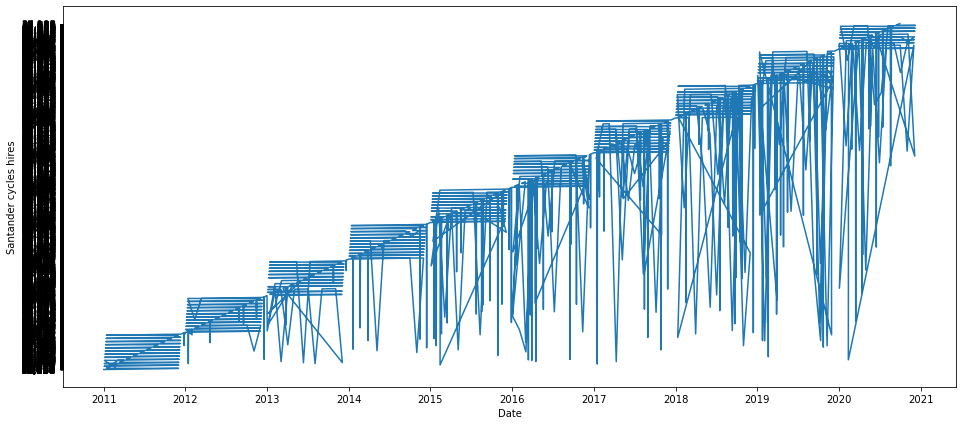

In [47]:
#### Plot the cycle data time series ####

# Use .index behind a dataframe to use the index values as an axis 
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(cycle_df.index, cycle_df['Number of Bicycle Hires'])
ax.grid(ls='--', c='k', alpha=0.2)
ax.set_ylim(0, 70000)
ax.set_xlabel('Date')
ax.set_ylabel('Santander cycles hires')
plt.show()
##############

## 1. Exploratory data analysis

Let's now explore the properties of the dataset. Time series data normally comprises of three main components:
- Trend represents the overall tendency of the data to increase or decrease over time.
- Seasonality relates to the presence of recurrent patterns that appear after regular intervals (like seasons).
- Random noise is often hard to explain and represents all those changes in the data that seem unexpected. Sometimes sudden changes are related to fixed or predictable events (i.e., public holidays).


### 1.1 Explore seasonal cycles using a 30-day rolling average

In [48]:
seasonal_cycle = cycle_df.rolling(window=30, center=True).mean().groupby(cycle_df.index.dayofyear).mean()
q25 = cycle_df.rolling(window=30, center=True).mean().groupby(cycle_df.index.dayofyear).quantile(0.25)
q75 = cycle_df.rolling(window=30, center=True).mean().groupby(cycle_df.index.dayofyear).quantile(0.75)


DataError: No numeric types to aggregate

In [ ]:
ndays_m = mdays.copy()
ndays_m[2] = 29
ndays_m = np.cumsum(ndays_m)
month_ticks = month_abbr[1:]
f, ax = plt.subplots(figsize=(10,7)) 

seasonal_cycle.plot(ax=ax, lw=2, color='b', legend=False)
ax.fill_between(seasonal_cycle.index, q25.values.ravel(), q75.values.ravel(), color='b', alpha=0.3)
ax.set_xticks(ndays_m + 15)
ax.grid(ls=':')
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Number of Santander cycles hires', fontsize=15);
ax.set_xlim(0, 365)
ax.set_ylim(10000, 40000)
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('30 days running average hourly cycling counts', fontsize=15)
plt.show()

### 1.2 Explore dependency on year and month via carpet plot/heatmap

Heatmaps (also called carpet plots) can give us useful information about the structure of the data. Pandas provides very handy functions to explore relevant dependencies. For example, here we show how the mean Number of Santander Cycles Hires varies as a function of the year and month. 

Although the number of hires seems to be increasing over time, this increase is not monotonic and probably depends on other factors as well. On the other hand, the carpet plot confirms the general trend shown before, with a higher usage of rented bikes over the warmer months. 

In [ ]:
month_year = cycle_df.copy()
month_year.loc[:,'year'] = month_year.index.year
month_year.loc[:,'month'] = month_year.index.month
month_year = month_year.groupby(['year','month']).mean().unstack()
month_year.columns = month_year.columns.droplevel(0)

month_year

In [ ]:
f, ax = plt.subplots(figsize=(12,6))

sns.heatmap(month_year, ax=ax, cmap=plt.cm.viridis, cbar_kws={'boundaries':np.arange(10000,45000,5000)})

cbax = f.axes[1]
[l.set_fontsize(13) for l in cbax.yaxis.get_ticklabels()]
cbax.set_ylabel('Santander cycles hires', fontsize=13)

[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];

ax.set_title('Santander cycles hires per year and month', fontsize=16)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Year', fontsize=15)
ax.set_yticklabels(np.arange(2011, 2021, 1), rotation=0);

### 1.3 Explore dependency on day of the week and month via carpet plot/heatmap
**TODO** Produce a new heatmap showing the dependency on the day of the week and month.

In [ ]:
#### TODO ####
# Explore dependency on day of the week and month #

##############

In [ ]:
f, ax = plt.subplots(figsize=(12,6))

sns.heatmap(month_day, ax = ax, cmap=plt.cm.viridis, cbar_kws={'boundaries':np.arange(10000,45000,5000)})

cbax = f.axes[1]
[l.set_fontsize(13) for l in cbax.yaxis.get_ticklabels()]
cbax.set_ylabel('Santander cycles hires', fontsize=13)

[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];

ax.set_title('Santander cycles hires per day of the week and month', fontsize=16)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Day of the week', fontsize=15)
ax.set_yticklabels(day_abbr[0:7]);

### 1.4 Explore weekdays and weekends trends

**TODO** We can also explore deeper trends by looking at differences between weekdays and weekends.

**HINT** Pandas DateTime indexes have a built-in method that extracts the day of week (`DataFrame.index.dayofweek`), where 0 is Monday and 6 is Sunday.

In [ ]:
#### TODO ####
## Extract weekdays and weekends trends ##

##########################

In [ ]:
#### TODO ####
## Plot weekdays and weekends general trends along with the 25% and 75% IQR to have a sense of the variation over time ##

##########################

## 2. Forecasting using Facebook Prophet

Nowadays, there are many models for the predictive analysis of time series data such as ARIMA (**A**uto-**R**egressive **I**ntegrated **M**oving **A**verage model), Auto-Regressive models, Exponential Smoothing, LSTM (**L**ong **S**hort **T**erm **M**emory), etc. 

Here, we will show how to use a novel approach based on the *Facebook Prophet* library. Fbprophet implements a Generalized Additive Model, and models a time-series as the sum (or multiplication) of different components (trends, periodic components, holidays and special events) allowing to incorporate additional regressors taken from outer sources. 
The main reference is [Taylor and Letham, 2017](https://peerj.com/preprints/3190.pdf)

See also [here](https://research.fb.com/prophet-forecasting-at-scale/) for the official announcement and [here](https://facebook.github.io/prophet/docs/quick_start.html#r-api) for the full documentation. 

The easiest way to install Prophet is through conda-forge. Open the Anaconda Prompt and type: `conda install -c conda-forge fbprophet`.

As largely explained in the quick start webpage, Prophet follows the `sklearn` model API. Hence we just need create an instance of the Prophet class and then call its `fit` and `predict` methods.

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
from fbprophet import Prophet

### 2.1 Base model

We first prepare the data in order to be ingested by Prophet. Therefore, we must change the name of the datetime column to `ds` and the target feature to `y`.

In [ ]:
def prepare_data(data, target_feature): 
    """
    prepare the data for ingestion by fbprophet: 
    see: https://facebook.github.io/prophet/docs/quick_start.html
    """
    new_data = data.copy()
    new_data.reset_index(inplace=True)
    new_data = new_data.rename({'datetime':'ds', '{}'.format(target_feature):'y'}, axis=1)
    
    return new_data

In [ ]:
cycle_df_new = prepare_data(data=cycle_df, target_feature='Number of Bicycle Hires')
cycle_df_new.head(5)

#### 2.1.1 The holidays package

Knowing when holidays and special events take place is often crucial when modelling time-series data. Here we make use of the `holidays` [package](https://github.com/dr-prodigy/python-holidays).

In [ ]:
import holidays

holidays_df = pd.DataFrame([], columns = ['ds','holiday'])
ldates = []
lnames = []
for date, name in sorted(holidays.England(years=np.arange(2011, 2020 + 1)).items()):
    ldates.append(date)
    lnames.append(name)
    
ldates = np.array(ldates)
lnames = np.array(lnames)
holidays_df.loc[:,'ds'] = ldates
holidays_df.loc[:,'holiday'] = lnames
holidays_df.holiday.unique()

In [ ]:
holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(lambda x : x.replace(' (Observed)',''))
holidays_df.head(5)

#### 2.1.2 Train test split and model fit

We have decided to use the data up to the 31st of July to train the model and the rest (last 2 months) as the holdout test set. 

In [ ]:
def train_test_split(data):
    
    
    train = data.set_index('ds').loc[:'2020-07-31', :].reset_index()
    test = data.set_index('ds').loc['2020-08-01':, :].reset_index()
    
    return train, test

In [ ]:
train, test = train_test_split(data=cycle_df_new)
train.head()

We now create a Prophet instance. The model has several parameters, the most important ones being the seasonalities. Here we set all the seasonalities but the daily to True (the data is on a daily basis, therefore we can't model in-day cycles).

Here we instantiate the simplest Prophet model, but you can set other parameters such as the prior scales for each component of your time-series, as well as the number of Fourier series to use to model the cyclic components.
Normally, larger prior scales and a higher order Fourier series will make the model more flexible, but at the cost of a potential overfit. Setting the hyperparameters is of crucial importance and it is normally done via cross-validation. 

In [ ]:
m = Prophet(holidays=holidays_df,
            seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False)

In [ ]:
m.fit(train)

The method `make_future_dataframe` creates an extension to the training data in the "future". Here our future is obviously the test set. 

In [ ]:
future = m.make_future_dataframe(periods=len(test), freq='1D')
future.tail()

The `predict` method produces a comprehensive DataFrame comprising of all the modelled components of the time-series.

In [ ]:
forecast = m.predict(future)
forecast

In [ ]:
f = m.plot_components(forecast, figsize=(12, 16))

In [ ]:
def make_predictions_df(forecast, data_train, data_test): 
    """
    Function to convert the output Prophet dataframe to a datetime index and append the actual target values at the end
    """
    forecast.index = pd.to_datetime(forecast.ds)
    data_train.index = pd.to_datetime(data_train.ds)
    data_test.index = pd.to_datetime(data_test.ds)
    data = pd.concat([data_train, data_test], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

def plot_predictions(forecast, start_date):
    """
    Function to plot the predictions 
    """
    f, ax = plt.subplots(figsize=(14, 8))
    
    train = forecast.loc[start_date:'2020-07-31',:]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = forecast.loc['2020-08-01':,:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    ax.axvline(forecast.loc['2020-08-01', 'ds'], color='k', ls='--', alpha=0.7)

    ax.grid(ls=':', lw=0.5)
    
    return f, ax


Since the target must be strictly positive (but our model doesn't know it), we clip predictions and confidence bands to have a lower value of 0.

In [ ]:
result = make_predictions_df(forecast, train, test)
result.loc[:,'yhat'] = result.yhat.clip(lower=0)
result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)
result.head()

In [ ]:
f, ax = plot_predictions(result, '2019-01-01')

At a first glance we can see that the model is not performing well. That is, it can capture the overall trend of the data in terms of annual and weekly oscillations, but is not able to generalise well on unseen data. We can spot the poor performance by employing a joint plot.

In [ ]:
def create_joint_plot(forecast, x='yhat', y='y', title=None): 

    g = sns.jointplot(x='yhat', y='y', data=forecast, kind="reg", color="b")
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)
    
    ax = g.fig.axes[1]
    if title is not None: 
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]
    ax.text(5000, 60000, "R = {:+4.2f}".format(forecast.loc[:,['y','yhat']].corr().iloc[0,1]), fontsize=16)
    ax.set_xlabel('Predictions', fontsize=15)
    ax.set_ylabel('Observations', fontsize=15)
    ax.set_xlim(0, 80000)
    ax.set_ylim(0, 80000)
    ax.grid(ls=':')
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')

In [ ]:
create_joint_plot(result.loc[:'2020-07-31', :], title='Train set')

In [ ]:
create_joint_plot(result.loc['2020-08-01':, :], title='Test set')

## 2.2 Model with extra-regressors: incorporating the effect of climate conditions

It is clear that the data is not enough to model the temporal evolution of the number of Santander Cycles Hires. Data scientists should be able to gather external data that they think might be useful for the problem at hand. In this case, is quite clear that weather conditions should strongly influence the amount of Londoners renting bikes. 

In [ ]:
df_weather = pd.read_pickle('LondonWeatherHourly.pkl')
df_weather

The weather data from a station located in NW3 is recorded every hour and reports the average temperature, wind speed, rain and cloud cover. For our purposes, we have to resample the data on a daily basis. Be careful, though. Bike rentals mostly happen during daytime, when people commute between home and work or other places. Therefore, we must label they daytime hours before resampling.

**TODO** We provide a simple function that labels as 1 the hours between 6 am and 8 pm and 0 otherwise. Use the `.apply` method in Pandas to create a new column in the DataFrame called `is_daytime_hour`. Then drop all the rows where the label is 0, because we will not consider those in the resampling process.

In [ ]:
def is_daytime_hour(datetime):
    if 6 <= datetime.hour <= 20:
        return 1
    else: 
        return 0

In [ ]:
### TODO ###

##########

**TODO** Now, we can resample the data on a daily basis using the well-known `.resample` method in Pandas. 

**NOTE** Features like temperature, wind speed and cloud cover can be averaged over the day when resampling. Whereas the precipation is cumulative over the day and taking the average value would not be a reasonable choice.

In [ ]:
###### TODO ######
# Resample the data on a daily basis. Check that the length of the resampled DataFrame matches the 
# length of the Cycle DataFrame (3561 rows)


**TODO** Concatenate the `cycle_df_new` DataFrame obtained in 2.1 with the resampled weather data.

In [ ]:
### TODO ###
# Concatenate the old dataframe with the additional regressors #


############

**TODO** Split the new data into training and test sets. Then instantiate a new Prophet model

In [ ]:
### TODO 1 ###
## Train-test split


###########

In [ ]:
#### TODO 2 ####
## Instantiate a new Prophet model


###########

**TODO** We now want to inform the model that extra-regressors are to be added. The `.add_regressor` method is a simple way of adding extra regressors. See [documentation](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors) for the usage.

In [ ]:
### TODO ###
# Add the 4 additional regressors to the model, namely 'temp', 'wind_speed', 'rain_1h' and 'clouds_all'


############

**TODO** Fit the model to the new training set.

In [ ]:
### TODO ###
# Fit the model 

############

**TODO** Make the future DataFrame

In [ ]:
### TODO ###
# Make the future DataFrame

############

**TODO** The `make_future_dataframe` method by default creates only the `ds` column. Since there are additional regressors we must append them on it. Create a new df called `futures` which includes the 4 additional regressors.

In [ ]:
#### TODO ####
#Create a dataframe called futures which includes the 4 additional regressors


##############

**TODO** Now we can forecast using the `predict` method as before and plot the componenents of the new model. As expected, you will notice that the extra-regressors are quite influential on the overall trend

In [ ]:
### TODO Forecast ###


In [ ]:
### TODO plot components ###


**TODO** Produce a plot of the predictions. Remember to clip the `yhat`, `yhat_lower` and `yhat_upper` columns to 0. You will notice that the extra regressors help locate additional fluctuations in the data. However, if you produce a joint plot you will see that the performance on the test set is still not enough (although strongly improved).

In [ ]:
## TODO produce predictions and plot ###

####

In [ ]:
create_joint_plot(result.loc[:'2020-07-31', :], title='Train set')

In [ ]:
create_joint_plot(result.loc['2020-08-01':, :], title='Test set')

## 2.3 Incorporate the effect of a pandemic

Choosing the right features and hyperparameters can be more an art than a science. We here want to show you a third possible model that incorporates a yearly seasonality if a specific year is affected by a pandemic or not. 

In [ ]:
def is_pandemic_affected(ds):
    date = pd.to_datetime(ds)
    return date.year == 2020

In [ ]:
df_with_weather_covid = df_with_weather.copy()
df_with_weather_covid['pandemic_affected'] = df_with_weather_covid['ds'].apply(is_pandemic_affected)
df_with_weather_covid['not_pandemic_affected'] = ~df_with_weather_covid['ds'].apply(is_pandemic_affected)

In [ ]:
df_with_weather_covid

In [ ]:
train_weather_covid, test_weather_covid = train_test_split(df_with_weather_covid)

Instantiate new Prophet model with yearly_seasonality set to `False`. 

In [ ]:
m = Prophet(holidays=holidays_df, 
            seasonality_mode='multiplicative',
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False)

In [ ]:
m.add_regressor('temp', mode='multiplicative')
m.add_regressor('wind_speed', mode='multiplicative')
m.add_regressor('rain_1h', mode='multiplicative')
m.add_regressor('clouds_all', mode='multiplicative')

In [ ]:
m.add_seasonality(name='pandemic_affected', period=365, fourier_order=3, mode='multiplicative', condition_name='pandemic_affected')
m.add_seasonality(name='not_pandemic_affected', period=365, fourier_order=3, mode='multiplicative', condition_name='not_pandemic_affected')

In [ ]:
m.fit(train_weather_covid)

In [ ]:
future = m.make_future_dataframe(periods=len(test_weather_covid), freq='1D')

In [ ]:
futures = pd.concat([future, df_weather_resampled.loc[:, ['temp', 'wind_speed', 'rain_1h', 'clouds_all']].reset_index()], axis=1)


In [ ]:
futures['pandemic_affected'] = futures['ds'].apply(is_pandemic_affected)
futures['not_pandemic_affected'] = ~futures['ds'].apply(is_pandemic_affected)
futures.head(5)

In [ ]:
forecast = m.predict(futures)

In [ ]:
result = make_predictions_df(forecast, train_weather_covid, test_weather_covid)
result.loc[:,'yhat'] = result.yhat.clip(lower=0)
result.loc[:,'yhat_lower'] = result.yhat_lower.clip(lower=0)
result.loc[:, 'yhat_upper'] = result.yhat_upper.clip(lower=0)

In [ ]:
f, ax = plot_predictions(result, '2019-01-01')

In [ ]:
create_joint_plot(result.loc[:'2020-07-31', :], title='Train set')

In [ ]:
create_joint_plot(result.loc['2020-08-01':, :], title='Test set')

Although the performance has not improved in terms of $R^2$, we can see that the information about the COVID-19 pandemic made the model able to discern that in 2020 the behaviour is different from the previous years. In fact, by looking at the `pandemic_affected` component we can observe several things:

- there is an unexpected and sudden drop in March and April, not present in the previous years.
- strong increase in the warmer months. This can be related to multiple causes  such as the particularly sunny summer, the relaxation of restrictions across the UK, people avoiding public transport, and the major changes to the cycling infrastructure made in London.






In [ ]:
f = m.plot_components(forecast, figsize=(12, 18))

# 3. Additional analyses (up to the student)

This final LAB is meant to stimulate your fantasy in preparation for the final assignment. In fact, we have purposedly shown you the basic usage of a powerful tool for time-series analysis and forecasting, and we would like you to play with the model's parameters and/or show if any improvements can be achieved by feeding the model with additional information. 

Here some suggestions:

- try to play with the model's components. How does the predictions/performance change by setting the `mode` parameter to additive? 
- can you fine tune the prior scales in order to reduce the overfitting issue?
- Prophet detects changepoints by first specifying a large number of potential time points at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) and then uses as few of them as possible. However, changepoints can be customised. Feel free to play with them by following the [documentation](https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet). 
- can you identify additional regressors or custom seasonalities that might help modelling the target?